#Leave EDA for now

In [4]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/bin/bash: line 1: cd: drive/Mydrive: No such file or directory


In [2]:
# !gdown https://drive.google.com/uc?id=1iYTFuf4DgxgYQzTQ_2da1vC9es_niPRr
# !tar -xvf dataset_student.zip

tar: dataset_student.zip: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [2]:
import glob
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import datetime
import time

In [4]:
# print(f"The training set has {len(os.listdir('dataset/train'))} videos, and each video has {len(glob.glob('dataset/train/video_00000/*.png'))} frames and {len(glob.glob('dataset/train/video_00000/*.npy'))} mask file for all frames")
# print(f"The validation set has {len(os.listdir('dataset/val'))} videos, and each video has {len(glob.glob('dataset/val/video_01000/*.png'))} frames and {len(glob.glob('dataset/val/video_01000/*.npy'))} mask file for all frames")
# print(f"The unlabeled set has {len(os.listdir('dataset/unlabeled'))} videos, and each video has {len(glob.glob('dataset/unlabeled/video_02000/*.png'))} frames and {len(glob.glob('dataset/unlabeled/video_02000/*.npy'))} mask file for all frames")

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train'

In [15]:
# mask = np.load('dataset/train/video_00000/mask.npy')
# print(f"The mask file has the shape {mask.shape}.")
# img = Image.open('dataset/train/video_00000/image_0.png')
# data = np.asarray(img, dtype="int32")
# print(f"Each image has the shape {data.shape}")

drive  sample_data


In [6]:
mask = np.load('drive/MyDrive/video_00000/mask.npy')
print(f"The mask file has the shape {mask.shape}.")
img = Image.open('drive/MyDrive/video_00000/image_0.png')
data = np.asarray(img, dtype="int32")
print(f"Each image has the shape {data.shape}")

The mask file has the shape (22, 160, 240).
Each image has the shape (160, 240, 3)


In [ ]:
# print("Let's visualize them:")

# def get_a_random_image(dir="dataset/train"):
#     all_videos = os.listdir(dir)
#     picked_video = random.choice(all_videos)
#     all_images = os.listdir(os.path.join(dir, picked_video))
#     picked_image = random.choice(all_images)
#     picked_image_idx = int(picked_image[len("image_"):-len(".png")])

#     img = Image.open(os.path.join(dir, picked_video, picked_image))
#     data = np.asarray(img, dtype="int32")


#     mask = np.load(os.path.join(dir, picked_video, "mask.npy"))

#     return data, mask[picked_image_idx]

In [7]:
print("Let's visualize them:")

def get_a_random_image(dir="drive/MyDrive"):
    all_videos = ['video_00000', 'video_00001', 'video_00002']
    picked_video = random.choice(all_videos)
    all_images = os.listdir(os.path.join(dir, picked_video))
    picked_image = random.choice(all_images)
    picked_image_idx = int(picked_image[len("image_"):-len(".png")])

    img = Image.open(os.path.join(dir, picked_video, picked_image))
    data = np.asarray(img, dtype="int32")

    mask = np.load(os.path.join(dir, picked_video, "mask.npy"))

    return data, mask[picked_image_idx]

Let's visualize them:


(-0.5, 239.5, 159.5, -0.5)

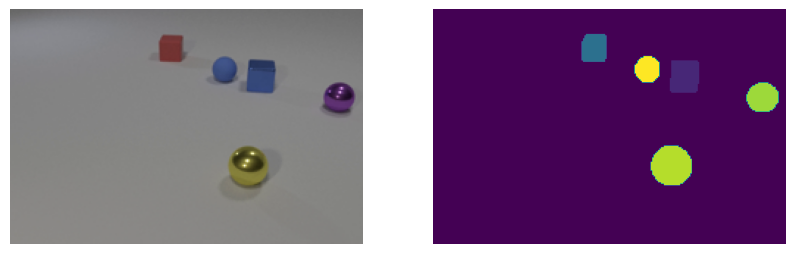

In [27]:
data, mask = get_a_random_image()
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(data)
plt.axis('off')

# Plot the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(mask)
plt.axis('off')

#Building a Model



#Slot Attention

to do:
1. test this code and make sure it runs on a small subset of data
2. inference - just return masks instead of recon_combined, recons, masks, slots
3. believe this is just for object discovery, not sure we'll get the different colors with this alone.

In [34]:
class SlotAttentionAutoEncoder(nn.Module):

      def __init__(self, resolution, num_slots, num_iterations, batch_size):
        """Builds the Slot Attention-based auto-encoder.

        Args:
          resolution: Tuple of integers specifying width and height of input image.
          num_slots: Number of slots in Slot Attention.
          num_iterations: Number of iterations in Slot Attention.
        """
        super().__init__()
        self.resolution = resolution
        self.num_slots = num_slots
        self.num_iterations = num_iterations
        self.batch_size = batch_size

        self.encoder_cnn = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=5),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=5),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=5),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=5),
                nn.ReLU(),
            )

        self.decoder_initial_size = (8, 8)
        self.decoder_cnn = nn.Sequential(
                nn.LazyConvTranspose2d(64, kernel_size=5, stride = (2,2)),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 64, kernel_size=5, stride = (1,1)),
                nn.ReLU(),
                # nn.ConvTranspose2d(64, 64, kernel_size=5, stride = (1, 1)),
                # nn.ReLU(),
                nn.ConvTranspose2d(64, 64, kernel_size=5, stride = (1, 1)),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 64, kernel_size=5, stride = (1, 1)),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 4, kernel_size=3, stride = (1, 1))
            )

        self.encoder_pos = SoftPositionEmbed(224, self.resolution) #224 rather than 64 due to size differences
        self.decoder_pos = SoftPositionEmbed(64, self.decoder_initial_size)

        self.layer_norm = nn.LayerNorm((self.batch_size, 9216, 224)) #check if this should be different..
        self.mlp = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(64))

        self.slot_attention = SlotAttention(
            num_iterations=self.num_iterations, #3
            num_slots=self.num_slots, #7
            slot_size=64,
            mlp_hidden_size=128)

      def forward(self,image):
          # `image` has shape: [batch_size, 160, 240, 3].

          # Convolutional encoder with position embedding.
          x = image.view(image.size()[0], image.size()[-1], image.size()[1], image.size()[2])
          x = self.encoder_cnn(x)  # CNN Backbone
          x = self.encoder_pos(x)  # Position embedding
          x = x.view(-1, x.size()[1] * x.size()[2], x.size()[-1]) # Flatten spatial dimensions (treat image as set).
          x = self.mlp(self.layer_norm(x))  # Feedforward network on set.
          # `x` has shape: [batch_size, width*height, input_size].

          # Slot Attention module.
          slots = self.slot_attention(x)
          # `slots` has shape: [batch_size, num_slots, slot_size].

          # Spatial broadcast decoder.
          x = self.spatial_broadcast(slots, (8, 8)) # self.decoder_initial_size I suppose just set this to whatever the slots shape is?
          # `x` has shape: [batch_size*num_slots, width_init, height_init, slot_size].
          x = self.decoder_pos(x)
          x = self.decoder_cnn(x)
          # `x` has shape: [batch_size*num_slots, width, height, num_channels+1].

          # Undo combination of slot and batch dimension; split alpha masks.
          recons, masks = self.unstack_and_split(x, batch_size=image.shape[0])
          # `recons` has shape: [batch_size, num_slots, width, height, num_channels].
          # `masks` has shape: [batch_size, num_slots, width, height, 1].

          # Normalize alpha masks over slots.
          masks = F.softmax(masks, dim=1)
          recon_combined = torch.sum(recons * masks, dim=1)  # Recombine image. #check that this is the right fn. i thought we needed sum? check the alg
          # `recon_combined` has shape: [batch_size, width, height, num_channels].

          return recon_combined, recons, masks, slots

      def spatial_broadcast(self, slots, resolution):
          """Broadcast slot features to a 2D grid and collapse slot dimension."""
          # `slots` has shape: [batch_size, num_slots, slot_size].
          slots = slots.reshape(-1, slots.size()[-1])[:, None, None, :]
          grid = torch.tile(slots, [1, resolution[0], resolution[1], 1])
          # `grid` has shape: [batch_size*num_slots, width, height, slot_size].
          return grid

      def unstack_and_split(self, x, batch_size, num_channels=3):
        """Unstack batch dimension and split into channels and alpha mask."""
        print(x.size())
        unstacked = x.view(batch_size, -1, x.size()[3], x.size()[1])
        print(unstacked.size())
        channels, masks = torch.split(unstacked, [num_channels, 1], dim=-1)
        return channels, masks



In [9]:
class SoftPositionEmbed(nn.Module):
  """Adds soft positional embedding with learnable projection."""

  def __init__(self, hidden_size, resolution):
    """Builds the soft position embedding layer.

    Args:
      hidden_size: Size of input feature dimension.
      resolution: Tuple of integers specifying width and height of grid.
    """
    super().__init__()
    self.linear = nn.LazyLinear(hidden_size, bias=True)
    self.grid = self.build_grid(resolution)

  def forward(self, inputs):
    return inputs + self.linear(torch.Tensor(self.grid))

  def build_grid(self, resolution):
    ranges = [np.linspace(0., 1., num=res) for res in resolution]
    grid = np.meshgrid(*ranges, sparse=False, indexing="ij")
    grid = np.stack(grid, axis=-1)
    grid = np.reshape(grid, [resolution[0], resolution[1], -1])
    grid = np.expand_dims(grid, axis=0)
    grid = grid.astype(np.float32)
    return np.concatenate([grid, 1.0 - grid], axis=-1)


In [10]:
class SlotAttention(nn.Module):
    def __init__(self, num_iterations, num_slots, slot_size, mlp_hidden_size, epsilon=1e-8):
        super().__init__()
        self.num_iterations = num_iterations
        self.num_slots = num_slots
        self.slot_size = slot_size
        self.mlp_hidden_size = mlp_hidden_size
        self.epsilon = epsilon

        # Linear maps for the attention module.
        self.W_q = nn.LazyLinear(self.slot_size, bias=False)
        self.W_k = nn.LazyLinear(self.slot_size, bias=False)
        self.W_v = nn.LazyLinear(self.slot_size, bias=False)

        # Normalization - moved directly to foward so that we could get the right sizes
        self.norm_inputs = nn.LayerNorm((2, 9216, 64))
        # self.norm_slots = nn.LayerNorm()
        # self.norm_mlp = nn.LayerNorm()

        # self.slots_mu = torch.nn.init.xavier_uniform(self.W_q.weight)
        # self.slots_log_sigma = torch.nn.init.xavier_uniform(self.W_q.weight)

        # Parameters for Gaussian init (shared by all slots) - this part might be off.. what's torch equivalent of self.add_weight
        # self.slots_mu = self.add_weight(
        #     initializer="glorot_uniform",
        #     shape=[1, 1, self.slot_size],
        #     dtype=float,
        #     name="slots_mu")
        # self.slots_log_sigma = self.add_weight(
        #     initializer="glorot_uniform",
        #     shape=[1, 1, self.slot_size],
        #     dtype=float,
        #     name="slots_log_sigma")

        # Slot update functions.
        #what should the input size be?
        # self.gru = nn.GRUCell(self.num_slots, self.slot_size) gru cell doesnt work with 3d?
        self.gru = nn.GRU(64, 64, num_layers=7, batch_first=True)
        self.mlp = nn.Sequential(
            nn.LazyLinear(self.mlp_hidden_size),
            nn.ReLU(),
            nn.LazyLinear(self.slot_size)
            )

    def forward(self, inputs):
      # `inputs` has shape [batch_size, num_inputs, inputs_size].
      inputs = self.norm_inputs(inputs)  # Apply layer norm to the input.
      k = self.W_k(inputs)  # Shape: [batch_size, num_inputs, slot_size].
      v = self.W_v(inputs)  # Shape: [batch_size, num_inputs, slot_size].

      # Initialize the slots. Shape: [batch_size, num_slots, slot_size].
      # revisit this!!
      # slots = self.slots_mu + torch.exp(self.slots_log_sigma) * torch.normal(
      #     mean=torch.zeros([inputs.size()[0], self.num_slots, self.slot_size]), std=torch.ones([inputs.size()[0], self.num_slots, self.slot_size]))
      slots = torch.exp(torch.tensor([1])) * torch.normal(
          mean=torch.zeros([inputs.size()[0], self.num_slots, self.slot_size]), std=torch.ones([inputs.size()[0], self.num_slots, self.slot_size]))
      self.norm_slots = nn.LayerNorm(slots.size())

      # Multiple rounds of attention.
      for _ in range(self.num_iterations):
        slots_prev = slots
        slots = self.norm_slots(slots)

        # Attention.
        q = self.W_q(slots)  # Shape: [batch_size, num_slots, slot_size].
        q *= self.slot_size ** -0.5  # Normalization.

        updates = self.scaled_dot_product_attention(q, k, v)
        # `updates` has shape: [batch_size, num_slots, slot_size].
        # Slot update.
        slots_prev = slots_prev.reshape(slots_prev.size()[1], slots_prev.size()[0], slots_prev.size()[2])
        slots, _ = self.gru(updates, slots_prev)
        self.norm_mlp = nn.LayerNorm(slots.size())
        slots += self.mlp(self.norm_mlp(slots))

      return slots

    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0)
        k_length = K.size(-2)

        scores = torch.matmul(Q, K.transpose(1, 2))  # (bs, n_heads, q_length, k_length)
        print(scores.size())
        A = F.softmax(scores, dim=-1)            # (bs, n_heads, q_length, k_length)
        A += self.epsilon
        A /= torch.sum(A, dim=-2, keepdim=True)

        # Get the weighted average of the values
        H = torch.matmul(A, V)                      # (bs, n_heads, q_length, dim_per_head)

        return H


In [11]:
#train step

batch_size = 64
num_slots = 7
num_iterations = 3
learning_rate = 0.0004
num_train_steps = 500000
warmup_steps = 10000
decay_rate = 0.5
decay_steps = 100000

def l2_loss(prediction, target):
    # return tf.reduce_mean(tf.math.squared_difference(prediction, target))
    loss = nn.MSELoss(reduction='mean')
    return loss(prediction, target)

def train_step(batch, model, optimizer):
    """Perform a single training step."""

    #zero the gradient
    optimizer.zero_grad()
    # Get the prediction of the models and compute the loss.
    preds = model(batch)
    recon_combined, recons, masks, slots = preds

    #!! do we want this loss between reconstructed image or the masks? also feed in masks if latter
    loss_value = l2_loss(batch, recon_combined)
    #backprop and step
    loss_value.backward()
    optimizer.step()
    #return loss

    return loss_value


def main(batch_size, num_slots, num_iterations, base_learning_rate, num_train_steps, warmup_steps, decay_rate, decay_steps):

      resolution = (64, 144)

      # Build dataset iterators, optimizers and model.
      # data_iterator = data_utils.build_clevr_iterator(
      #     batch_size, split="train", resolution=resolution, shuffle=True,
      #     max_n_objects=6, get_properties=False, apply_crop=True)

      data_iterator = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

      model = SlotAttentionAutoEncoder(resolution, num_slots, num_iterations, batch_size)

      optimizer = torch.optim.Adam(model.parameters(), lr=base_learning_rate)

      # Prepare checkpoint manager.
      global_step = torch.tensor(0)
      # ckpt = tf.train.Checkpoint(
      #     network=model, optimizer=optimizer, global_step=global_step)
      # ckpt_manager = tf.train.CheckpointManager(
      #     checkpoint=ckpt, directory=FLAGS.model_dir, max_to_keep=5)
      # ckpt.restore(ckpt_manager.latest_checkpoint)
      # if ckpt_manager.latest_checkpoint:
      #   logging.info("Restored from %s", ckpt_manager.latest_checkpoint)
      # else:
      #   logging.info("Initializing from scratch.")

      start = time.time()

      for i in range(num_train_steps):
          for j, data in enumerate(data_iterator, 0):
              batch, masks = data
              batch, masks = batch.float(), masks.float()
              #don't worry about warm up at the moment?
              # Learning rate warm-up.
              # if global_step < warmup_steps:
              #   learning_rate = base_learning_rate * tf.cast(
              #       global_step, tf.float32) / tf.cast(warmup_steps, tf.float32)
              # else:

              learning_rate = base_learning_rate
              # learning_rate = learning_rate * (decay_rate ** (
              #     tf.cast(global_step, tf.float32) / tf.cast(decay_steps, tf.float32)))
              optimizer.lr = learning_rate#.numpy()

              loss_value = train_step(batch, model, optimizer)

              # Update the global step. We update it before logging the loss and saving
              # the model so that the last checkpoint is saved at the last iteration.
              global_step.assign_add(1)

              # Log the training loss.
              if not global_step % 100:
                print("Step: %s, Loss: %.6f, Time: %s",
                            global_step.numpy(), loss_value,
                            datetime.timedelta(seconds=time.time() - start))

              # # We save the checkpoints every 1000 iterations.
              # if not global_step  % 1000:
              #   # Save the checkpoint of the model.
              #   saved_ckpt = ckpt_manager.save()
              #   logging.info("Saved checkpoint: %s", saved_ckpt)



In [12]:
def get_random_images(dir="drive/MyDrive"):
    all_videos = ['video_00000', 'video_00001', 'video_00002']
    picked_video = random.choice(all_videos)
    all_images = os.listdir(os.path.join(dir, picked_video))
    data = []

    for i in range(4):

        picked_image = random.choice(all_images)
        picked_image_idx = int(picked_image[len("image_"):-len(".png")])
        img = Image.open(os.path.join(dir, picked_video, picked_image))
        img_data = np.asarray(img, dtype="int32")
        mask = np.load(os.path.join(dir, picked_video, "mask.npy"))[picked_image_idx]

        data.append((img_data, mask))

    return data


In [35]:
trainset = get_random_images()
#set equal to just one or two videos for debugging

#train the model
main(batch_size=2, num_slots=7, num_iterations=3, base_learning_rate=learning_rate, num_train_steps=num_train_steps, warmup_steps=warmup_steps, decay_rate=decay_rate, decay_steps=decay_steps)


torch.Size([2, 7, 9216])
torch.Size([2, 7, 9216])
torch.Size([2, 7, 9216])
torch.Size([14, 4, 33, 145])
torch.Size([2, 1015, 33, 4])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 33, 3])) that is different to the input size (torch.Size([2, 160, 240, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (240) must match the size of tensor b (33) at non-singleton dimension 2

In [ ]:
#inference
preds = model(batch["image"], training=False)
recon_combined, recons, masks, slots = preds
torch.Size([14, 4, 179, 1075])
torch.Size([2, 1253, 1075, 4])

#we want just masks

#RAFT
- RAFT breakdown following https://towardsdatascience.com/optical-flow-with-raft-part-1-f984b4a33993
- feel free to update/edit as necessary

In [ ]:
# def feature_encoder(img1, img2, D):
#     '''CNN consisting of ~6 residual blocks and downsampling
#     Operates on shared weights
#     Uses instance normalization
#     input: images of size 160, 240, 3; D is number of feature maps
#     output: feature maps of each input image with size 20, 30, D
#     '''
#     return img1_fm, img2_fm

In [ ]:
# def context_encoder(img1, c, h):
#     '''Similar architecture to feature_encoder CNN
#     Only extracts weights of img1
#     Uses batch normalization
#     input: image of size 160, 240, 3; c is number of context feature maps and h is number of hidden feature maps
#     output:feature maps of input image with size 20, 30, c+h
#     '''
#     return context_hidden_fm

In [ ]:
# def visual_similarity(img1_fm, img2_fm):
#     '''Compute the 4D correlation of the feature maps by taking the dot product
#     of feature maps for each image and summing accross all feature maps (along dim D)
#     input: feature maps from the feature encoder
#     output: correlation features of size
#     '''
#     return corr_features

In [ ]:
# #optional implementation as a means to address larger pixel displacements
# #w/o this visual similarity may work well for small displacements but strugger with larger ones
# def correlation_pyramid(img1_fm, img2_fm):
#     '''use visual similarity function and average pooling of the last two dimensions
#     to get multuple levels of correlation
#     Add resampling to get correlation features in the right shape for the update block
#     input: feature maps from the feature encoder
#     output: correlation features of size
#     '''
#     return corr_features

In [ ]:
# #maybe break this function up more
# def iterative_update(corr_features, current_flow, context_hidden_fm, warm_start=0):
#     '''Recurrently update flow, then pass through a flow head
#     Concat correlation features, current flow estimate, context features and hidden features
#     In each iteration update the flow: new_flow = current_flow + delta_flow
#     Final conv layers to resize estimate to 20, 30, 2
#     Convex Upsampling to size 20, 30, (8*8)
#     Obtain a weighted combination over the neighborhood and reshape to get a 20x30x2 flow field
#     Warm start can be optionally implemented if we have the previously projected estimation and we'd like to start from there instead of 0
#     '''
#     return final_flow

In [ ]:
# def training(final_flow, ground_truth):
#     '''Loss is the sum of weighted l1 distances between the flow predictions and ground truth,
#      with exponentially increasing weights
#      '''
#     return predictions